In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest'], subs)
print(X[0].shape)

847
(847, 264, 124)


In [341]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83
N = X[0].shape[0]

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [tr/20*N, 0.8*N], 2*N)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [ts for ts in filter_design_ts(X[0])]
ts = np.stack(ts)
print(ts.shape)

(847, 264, 124)


In [496]:
### import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

mseLoss = nn.MSELoss()

x = torch.from_numpy(ts).float().cuda()

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class EffGroup(nn.Module):
    def __init__(self):
        super(EffGroup, self).__init__()
        self.ec = nn.Parameter(1e-3*torch.rand(264,264).float().cuda())
        
    def get_ec(self):
        return self.ec
#         return mask(self.ec)
        
    def forward(self, x):
        xi = x[:,:,:-1]
        xhat = torch.einsum('nat,ab->nbt',xi,self.get_ec())
        return xhat
    
class EffSub(nn.Module):
    def __init__(self, n):
        super(EffSub, self).__init__()
        self.a = nn.Parameter(1e-3*torch.rand(n,50,264).float().cuda())
        self.b = nn.Parameter(1e-3*torch.rand(n,50,264).float().cuda())
        self.c = mask(torch.ones(264,264).float().cuda()).unsqueeze(0)
        
    def get_ec(self):
        ec = torch.einsum('nab,nac->nbc',self.a,self.b)
#         ec = ec*self.c
        return ec
        
    def forward(self, x):
        xi = x[:,:,:-1]
        xhat = torch.einsum('nat,nab->nbt',xi,self.get_ec())
        return xhat
    
effgrp = EffGroup()
effsub = EffSub(x.shape[0])
optim = torch.optim.Adam([
    {'params': effgrp.parameters(), 'lr': 1e-2}, 
    {'params': effsub.parameters(), 'lr': 1e-2, 'weight_decay': 1e-1},
])

nEpochs = 1000
pPeriod = 100

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    xgrp = effgrp(x)
    xsub = effsub(x)
    xhat = xgrp+xsub
    loss = mseLoss(xhat, x[:,:,1:])
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)} lr: {sched._last_lr}')
        
print('Complete')

0 56.79085922241211 lr: [0.01, 0.01]
100 22.430519104003906 lr: [0.0095, 0.0095]
200 17.415868759155273 lr: [0.0095, 0.0095]
300 16.791248321533203 lr: [0.00857375, 0.00857375]
400 14.890981674194336 lr: [0.0081450625, 0.0081450625]
500 14.470709800720215 lr: [0.006983372960937498, 0.006983372960937498]
600 14.294428825378418 lr: [0.005987369392383786, 0.005987369392383786]
700 14.09824275970459 lr: [0.005987369392383786, 0.005987369392383786]
800 14.01522445678711 lr: [0.0048767497911552955, 0.0048767497911552955]
900 13.932594299316406 lr: [0.0048767497911552955, 0.0048767497911552955]
999 14.100119590759277 lr: [0.00463291230159753, 0.00463291230159753]
Complete


/tmp/ipykernel_54262/2383259068.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


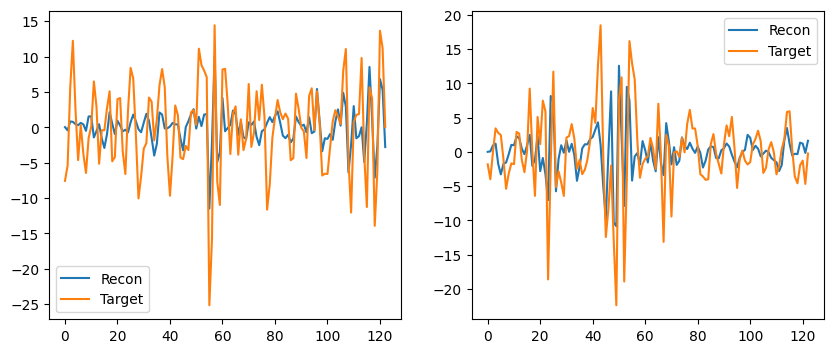

In [497]:
# View reconstruction

import matplotlib.pyplot as plt

xhatnp = xsub.detach().cpu().numpy()
xonp = x[:,:,1:].detach().cpu().numpy()

roi = 100

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(xhatnp[4,roi],label='Recon')
ax[0].plot(xonp[4,roi],label='Target')
ax[0].legend()
ax[1].plot(xhatnp[3,roi],label='Recon')
ax[1].plot(xonp[3,roi],label='Target')
ax[1].legend()
fig.show()

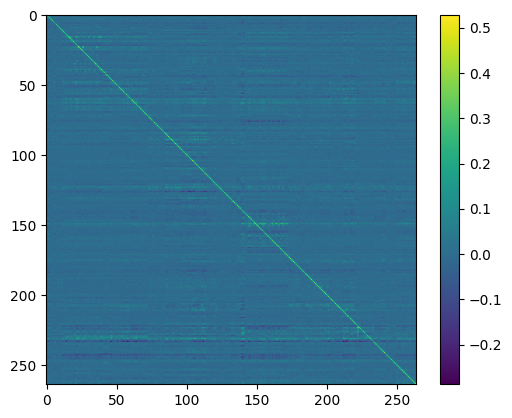

In [513]:
def subec(effsub, i):
    with torch.no_grad():
        ec = effsub.get_ec()[i]
        return ec.detach().cpu().numpy()
    
plt.imshow(subec(effsub, 13)+effgrp.get_ec().detach().cpu().numpy())
plt.colorbar()
plt.show()

In [509]:
# xec = torch.cat([effsub.a, effsub.b], dim=2).detach().clone()
xec = effsub.get_ec() + effgrp.get_ec()
xec = xec.clone().detach()
xec = xec.reshape(xec.shape[0],-1)
# mu = torch.mean(xec, dim=0, keepdims=True)
# std = torch.std(xec, dim=0, keepdims=True)
# xec = (xec-mu)/std

xectr = xec[:600]
xect = xec[600:]

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[:600]
yt = y_t[600:]

print(xec.shape)
print(xectr.shape)
print(xect.shape)
print(y.shape)

torch.Size([847, 69696])
torch.Size([600, 69696])
torch.Size([247, 69696])
(847,)


In [500]:
import sys 

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [510]:
class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(dim,1).float().cuda()
        
    def forward(self, x):
        y = self.l0(x).squeeze()
        return y

mlp = MLP(xec.shape[1])
optim = torch.optim.Adam(mlp.parameters(), lr=1e-1, weight_decay=5e-2)

nEpochs = 10000
pPeriod = 1000

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = mlp(xectr)
    loss = mseLoss(yhat, ytr)
#     l1loss = 1e-1*(torch.sum(torch.abs(mlp.l0.weight))+torch.sum(torch.abs(mlp.l0.bias)))
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')
print(mseLoss(mlp(xect), yt)**0.5)

0 184.63571609049535 lr: [0.1]
1000 28.57951532634979 lr: [0.07350918906249998]
2000 28.56505241091431 lr: [0.0009393946474175996]
3000 28.56485262808234 lr: [9.289076879966705e-06]
4000 28.56484408119205 lr: [1.9937959796869698e-06]
5000 28.564828055765865 lr: [1.9937959796869698e-06]
6000 28.564807756879794 lr: [1.9937959796869698e-06]
7000 28.564777842705602 lr: [1.9937959796869698e-06]
8000 28.564738313213088 lr: [1.9937959796869698e-06]
9000 28.56468916836233 lr: [1.9937959796869698e-06]
9999 28.564627202995208 lr: [1.9937959796869698e-06]
Complete
tensor(36.8484, device='cuda:0', grad_fn=<PowBackward0>)


In [512]:
sim = LatSim(1, xec.unsqueeze(1), dp=0.3, edp=0, wInit=1e-4, dim=10, temp=1)
optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4)

nEpochs = 1000
pPeriod = 100

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = sim(xectr.unsqueeze(1), [ytr])[0][0]
    loss = mseLoss(yhat, ytr)
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')

print(mseLoss(sim(xec.unsqueeze(1), [y_t], torch.arange(600,y_t.shape[0]))[0][0][600:], yt)**0.5)

0 40.081035164810956 lr: [0.0001]
100 30.92264775278742 lr: [0.0001]
200 21.635936992218525 lr: [0.0001]
300 17.428104617726113 lr: [9.025e-05]
400 15.567098773020758 lr: [6.983372960937497e-05]
500 14.854880695204185 lr: [4.876749791155295e-05]
600 15.018522397847548 lr: [3.2353354497370904e-05]
700 15.115292294799547 lr: [2.2593554099256555e-05]
800 14.543991179980802 lr: [1.4989025404881544e-05]
900 14.022958731381593 lr: [9.446824413773763e-06]
999 14.391444610549549 lr: [5.953855510552941e-06]
Complete
tensor(42.4809, device='cuda:0', grad_fn=<PowBackward0>)
